In [94]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_row', 22)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 200)

In [2]:
# This function will return the top 10 shows with the highest cosine similarity value
def top_factors(item_sim_df, factor_name):
    count = 1
    print('Similar shows to {} include:\n'.format(factor_name))
    result = item_sim_df.loc[~item_sim_df.index.isin([factor_name]), factor_name].sort_values(ascending = False)[:10]
    for item, score in result.items():
        print('No. {}: {}({:.2f})'.format(count, item , score))
        count +=1

In [3]:
# This function will return the top 5 crops with the highest similarity value 
def top_crops(user_sim_df, crop):
    print('Most Similar crops({}):\n'.format(crop))
    result = user_sim_df.sort_values(by=crop, ascending=False).loc[:,crop][1:11]
    for crop, sim in result.items():
        print('crop #{0}, Similarity value: {1:.2f}'.format(crop, sim))

In [4]:
# This function constructs a list of lists containing the highest rated shows per similar user
# and returns the name of the show along with the frequency it appears in the list
def similar_user_recs(user_sim_df, user):
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11] 
    best = []
    most_common = {}

    for i in sim_users:
        result_sorted = piv_norm.loc[:, i].sort_values(ascending = False)
        best.append(result_sorted.index[:5].tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5]   


In [5]:
# Main function for collaborative filtering based recommendation system
def recommendation_collaborative(dataframe):
    crop = dataframe
    
    print(crop)
    print()
    
    crops_label = crop['label'].unique().tolist()

    columns = crop.columns.tolist()
    columns.pop()
    sub_columns = columns.copy()
    columns.insert(0,'crop')

    big_list = []
    for index,i in enumerate(crops_label):
        big_list.append([0 for _ in range(8)])
        big_list[index][0] = i
        for inner_index, n in enumerate(columns[1:]):
            big_list[index][inner_index+1] = crop[crop['label']==i][n].mean()

    separate_list= []
    for index, i in enumerate(big_list):
        for n in sub_columns:
            temp_list = [0 for _ in range(3)]
            temp_list[0] = i[0]
            temp_list[1] = n
            temp_list[2] = crop[crop['label']==i[0]][n].mean()
            separate_list.append(temp_list)

    df = pd.DataFrame(separate_list, columns=['crop','factors','value'])
    
    print(df)
    print()
    
    piv = df.pivot_table(index=['crop'], columns=['factors'], values='value')
    
    print(piv)
    print()

    # Normalize the values
    scaler = RobustScaler()
    piv[piv.columns] = scaler.fit_transform(piv[piv.columns])
    piv_norm = piv
    
    print(piv_norm)
    print()
    
    piv_norm = piv_norm.T
    piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

    # Our data needs to be in a sparse matrix format to be read by the following functions
    piv_sparse = sp.sparse.csr_matrix(piv_norm.values)

    item_similarity = cosine_similarity(piv_sparse)
    user_similarity = cosine_similarity(piv_sparse.T)

    item_sim_df = pd.DataFrame(item_similarity, index = piv_norm.index, columns = piv_norm.index)
    user_sim_df = pd.DataFrame(user_similarity, index = piv_norm.columns, columns = piv_norm.columns)
    
    
    print(item_sim_df)
    print()
    print(user_sim_df)
    print()

    return item_sim_df, user_sim_df, piv_norm

In [44]:
# Main function for collaborative filtering based recommendation system
def SVD_Method(dataframe, crop_input):
    crop = dataframe
    
    print(crop)
    print()
    
    crops_label = crop['label'].unique().tolist()

    columns = crop.columns.tolist()
    columns.pop()
    sub_columns = columns.copy()
    columns.insert(0,'crop')

    big_list = []
    for index,i in enumerate(crops_label):
        big_list.append([0 for _ in range(8)])
        big_list[index][0] = i
        for inner_index, n in enumerate(columns[1:]):
            big_list[index][inner_index+1] = crop[crop['label']==i][n].mean()

    separate_list= []
    for index, i in enumerate(big_list):
        for n in sub_columns:
            temp_list = [0 for _ in range(3)]
            temp_list[0] = i[0]
            temp_list[1] = n
            temp_list[2] = crop[crop['label']==i[0]][n].mean()
            separate_list.append(temp_list)

    df = pd.DataFrame(separate_list, columns=['crop','factors','value'])
    
    print(df)
    print()
    
    piv = df.pivot_table(index=['crop'], columns=['factors'], values='value')
    
    print(piv)
    print()

    # Normalize the values
    scaler = RobustScaler()
    piv[piv.columns] = scaler.fit_transform(piv[piv.columns])
    piv_norm = piv
    
    print(piv_norm)
    print()
    
    crop_name = piv_norm.index
    crop_name_list = list(crop_name)

    SVD = TruncatedSVD(n_components=7)
    matrix = SVD.fit_transform(piv_norm)
    corr = np.corrcoef(matrix)
    
    coffey_hands = crop_name_list.index(crop_input)
    
    corr_coffey_hands = corr[coffey_hands]
    
    temp_df = pd.DataFrame(corr_coffey_hands, columns=['corr'], index=crop_name)
    temp_df = temp_df.sort_values(by=['corr'], ascending=False)
    temp_df = temp_df[temp_df['corr']>=0.6]
    
    print(temp_df)
    print()
    
    temp = list(temp_df.index)[:10]
    temp.remove(crop_input)
    
    sns.heatmap(corr, annot=False)
    
    print(temp)
    print()
    print(crop_name.tolist())
    

In [136]:
# Main function for collaborative filtering based recommendation system
def SVD_rate_matrix(dataframe):
    crop = dataframe
    
    print(crop)
    print()
    
    crops_label = crop['label'].unique().tolist()

    columns = crop.columns.tolist()
    columns.pop()
    sub_columns = columns.copy()
    columns.insert(0,'crop')

    big_list = []
    for index,i in enumerate(crops_label):
        big_list.append([0 for _ in range(8)])
        big_list[index][0] = i
        for inner_index, n in enumerate(columns[1:]):
            big_list[index][inner_index+1] = crop[crop['label']==i][n].mean()

    separate_list= []
    for index, i in enumerate(big_list):
        for n in sub_columns:
            temp_list = [0 for _ in range(3)]
            temp_list[0] = i[0]
            temp_list[1] = n
            temp_list[2] = crop[crop['label']==i[0]][n].mean()
            separate_list.append(temp_list)

    df = pd.DataFrame(separate_list, columns=['crop','factors','value'])
    
    piv = df.pivot_table(index=['crop'], columns=['factors'], values='value')

    # Normalize the values
    scaler = RobustScaler()
    piv[piv.columns] = scaler.fit_transform(piv[piv.columns])
    piv_norm = piv
    
    piv_norm = piv_norm.T
    piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

    # Our data needs to be in a sparse matrix format to be read by the following functions
    piv_sparse = sp.sparse.csr_matrix(piv_norm.values)

    crop_similarity = cosine_similarity(piv_sparse.T)
    crop_sim_df = pd.DataFrame(crop_similarity, index = piv_norm.columns, columns = piv_norm.columns)
    
    sample_df = pd.DataFrame(crop, columns=crop_sim_df.index.values)
    sample_df['label'] = crop['label'].sort_values()
    sample_df = sample_df.sort_values(by='label')
    
    for i in crops_label:
        sample_df.loc[sample_df['label']==i] = crop_sim_df[i].values.tolist()+[i]
    sample_df = sample_df.sort_index()
    
    save_original_df = sample_df.drop(columns=['label'])
    
    for i in crops_label:
        tempdf = sample_df.sample(440)
        tempdf[i] = 0
        sample_df.update(tempdf)
    
    sample_df = sample_df.drop(columns=['label'])
    
    rating_table = sample_df.copy()
    
    for col in range(len(rating_table.columns)):
        col_update=[]
        # Find the average of the columns.
        col_num = [i for i in rating_table.iloc[:,col] if i != 0]
        col_mean = sum(col_num)/len(col_num)

        # The '0' row is filled with the average value obtained above.
        col_update = [i if i != 0 else col_mean for i in rating_table.iloc[:,col]]

        # An updated column made from a list is newly added to the existing data frame column.
        rating_table.iloc[:,col] = col_update
    save_rating_table = rating_table.copy()
    
    row_mean_list = []
    for row in range(len(rating_table)):
        # Create a list space to put the average subtracted values for each value.
        row_update=[]

        # Row mean value
        row_mean=sum(rating_table.iloc[row,:])/len(rating_table.iloc[row,:])

        # Subtract the row mean value from all column values in that row.
        row_update = [i-row_mean for i in rating_table.iloc[row,:]]

        rating_table.iloc[row,:] = row_update
        row_mean_list.append(row_mean)
        
    # Let's use TruncatedSVD to reduce dimensions. Here k is set to 12. n_iter is the number of iterations of a random SVD calculator.
    svd = TruncatedSVD(n_components=12, n_iter=5)

    # model fitting with data
    svd.fit(np.array(rating_table))

    # Through the following code, matrices U, S, and V^T may be included in variables, respectively.
    U=svd.fit_transform(np.array(rating_table))
    Sigma=svd.explained_variance_ratio_
    VT= svd.components_
        
    ratings_reduced= pd.DataFrame(np.matmul(np.matmul(U, np.diag(Sigma)), VT))
    restore_rating = ratings_reduced.copy()
    
    crops_label.sort()
    restore_rating.columns = crops_label
    
    for row in range(len(restore_rating)):
        restore_rating.iloc[row,:] += row_mean_list[row]
    
    fill_with_restore_df = sample_df.copy()
    
    for n in range(len(fill_with_restore_df.columns)):
        for i in range(len(fill_with_restore_df)):
            if fill_with_restore_df.iloc[i,n] == 0:
                fill_with_restore_df.iloc[i,n] = restore_rating.iloc[i,n]
    
    
    
    print('missing matrix')
    print(sample_df)
    
    print('original matrix (no missing data)')
    print(save_original_df)
    
    print('filling with mean matrix')
    print(save_rating_table)
    
    print('restored matrix (make missing data and filling with restore with SVD)')
    print(fill_with_restore_df)
    
    print('MSE (original matrix <-> missing matrix)')
    print(mean_squared_error(save_original_df,sample_df))
    
    print('MSE (original matrix <-> mean matrix)')
    print(mean_squared_error(save_original_df,save_rating_table))
    
    print('MSE (original matrix <-> restored with SVD matrix)')
    print(mean_squared_error(save_original_df,fill_with_restore_df))

In [137]:
# MAIN #
crop = pd.read_csv('Crop_recommendation.csv')
SVD_rate_matrix(crop)

        N   P   K  temperature   humidity        ph    rainfall   label
0      90  42  43    20.879744  82.002744  6.502985  202.935536    rice
1      85  58  41    21.770462  80.319644  7.038096  226.655537    rice
2      60  55  44    23.004459  82.320763  7.840207  263.964248    rice
3      74  35  40    26.491096  80.158363  6.980401  242.864034    rice
4      78  42  42    20.130175  81.604873  7.628473  262.717340    rice
...   ...  ..  ..          ...        ...       ...         ...     ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  coffee
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  coffee
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  coffee
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

missing matrix
         apple    banana  blackgram  chickpea  ...  pigeonpeas  pomegranate     rice  watermelo

In [7]:
# MAIN #
crop = pd.read_csv('Crop_recommendation.csv')
factor_sim_df, crop_sim_df, piv_norm = recommendation_collaborative(crop)

        N   P   K  temperature   humidity        ph    rainfall   label
0      90  42  43    20.879744  82.002744  6.502985  202.935536    rice
1      85  58  41    21.770462  80.319644  7.038096  226.655537    rice
2      60  55  44    23.004459  82.320763  7.840207  263.964248    rice
3      74  35  40    26.491096  80.158363  6.980401  242.864034    rice
4      78  42  42    20.130175  81.604873  7.628473  262.717340    rice
...   ...  ..  ..          ...        ...       ...         ...     ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  coffee
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  coffee
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  coffee
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

       crop      factors       value
0      rice            N   79.890000
1      rice            P   47.580000

In [29]:
# Function Example
top_factors(factor_sim_df, 'K') #ex.N,K,P,rainfall
print()
top_crops(crop_sim_df, 'jute') #ex.rice,apple,jute
# print(similar_user_recs(crop_sim_df, 'coffee')) #ex. rice,apple,jute

Similar shows to K include:

No. 1: P(0.76)
No. 2: humidity(0.05)
No. 3: N(0.04)
No. 4: rainfall(-0.03)
No. 5: temperature(-0.18)
No. 6: ph(-0.26)

Most Similar crops(jute):

crop #rice, Similarity value: 0.94
crop #coffee, Similarity value: 0.81
crop #papaya, Similarity value: 0.40
crop #coconut, Similarity value: 0.40
crop #banana, Similarity value: 0.39
crop #cotton, Similarity value: 0.38
crop #apple, Similarity value: 0.19
crop #chickpea, Similarity value: 0.16
crop #watermelon, Similarity value: 0.13
crop #maize, Similarity value: 0.12


        N   P   K  temperature   humidity        ph    rainfall   label
0      90  42  43    20.879744  82.002744  6.502985  202.935536    rice
1      85  58  41    21.770462  80.319644  7.038096  226.655537    rice
2      60  55  44    23.004459  82.320763  7.840207  263.964248    rice
3      74  35  40    26.491096  80.158363  6.980401  242.864034    rice
4      78  42  42    20.130175  81.604873  7.628473  262.717340    rice
...   ...  ..  ..          ...        ...       ...         ...     ...
2195  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2196   99  15  27    27.417112  56.636362  6.086922  127.924610  coffee
2197  118  33  30    24.131797  67.225123  6.362608  173.322839  coffee
2198  117  32  34    26.272418  52.127394  6.758793  127.175293  coffee
2199  104  18  30    23.603016  60.396475  6.779833  140.937041  coffee

[2200 rows x 8 columns]

       crop      factors       value
0      rice            N   79.890000
1      rice            P   47.580000

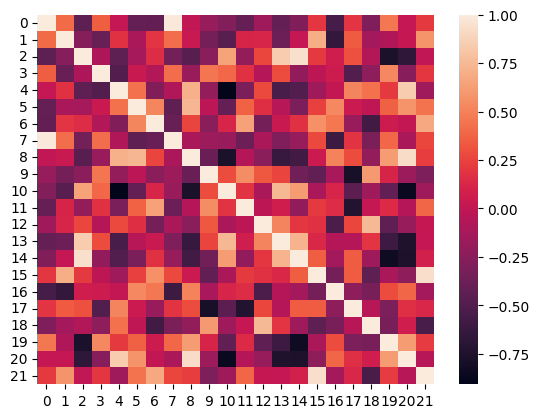

In [45]:
# MAIN #
crop = pd.read_csv('Crop_recommendation.csv')
crop_name = 'jute'
SVD_Method(crop, crop_name)